# Hierarchical model fit on Splatter datasets

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


## Splatter 1 (small and simple)

## Loading data

In [3]:
with open('../Splatter/smallsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/smallsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [4]:
print(data[:6,:6])
print(labels[:6])

[[ 38   0   3   4  24   2]
 [  8   4   0  17  12   2]
 [ 34   0   2  14  52   2]
 [ 22   0   0  20  43   0]
 [ 25   0   3   8  20   5]
 [ 58   1   8   1 100  15]]
[3 3 0 0 3 1]


In [5]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 95
1 	 116
2 	 88
3 	 98
4 	 103


### Loading/Saving  formatted data

In [74]:
# with open('splat_small.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [2]:
data, labels = pickle.load(open('splat_small.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 400)


## Pre-analysis

### Some explames of distributions of genes

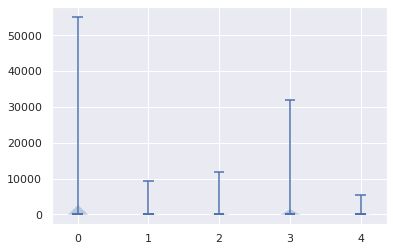

In [76]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

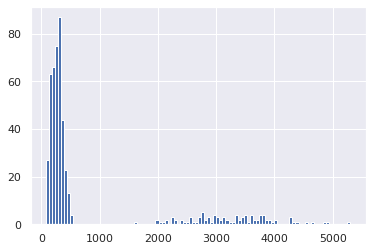

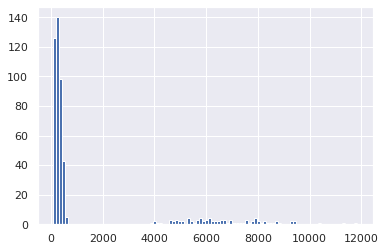

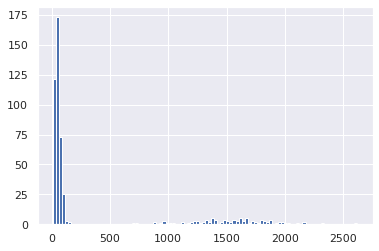

In [3]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(3):
    plt.hist(data[:,genes[i]], bins=100)
    plt.show()

## Preprocessing

### Transform data

In [4]:
data = np.log2(data+1)

In [5]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

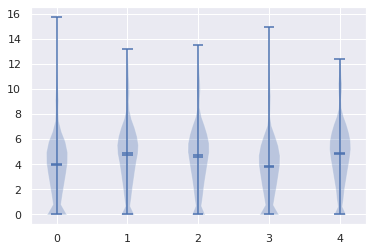

In [6]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

In [8]:
# with open('smallsplat_prep_whole.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [5]:
data, labels = pickle.load(open('smallsplat_prep_whole.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 400)


### Number of clusters is estimated fairly high

In [11]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

Estimated number of clusters:  19


### Clear classes can be observed

In [106]:
n_test = 5
labels_test = KMeans(n_test).fit(data).labels_

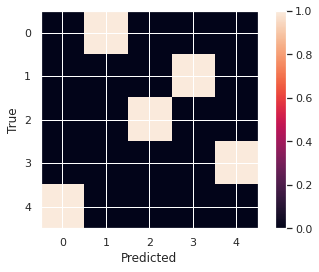

In [107]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [108]:
adjusted_rand_score(labels, labels_test)

1.0

## Analysis

Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Latent data on top level:


Estimated number of clusters on top-level data: 3 (out of a maximum of) 3


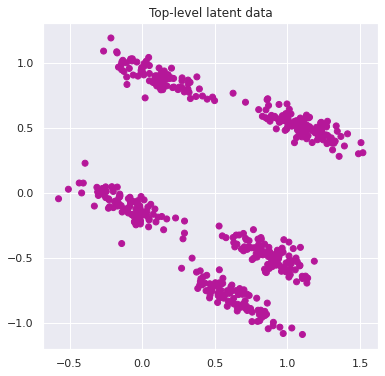

level 1:
Cluster 1:
First guess: cluster 1 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 2 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 3 clusters.


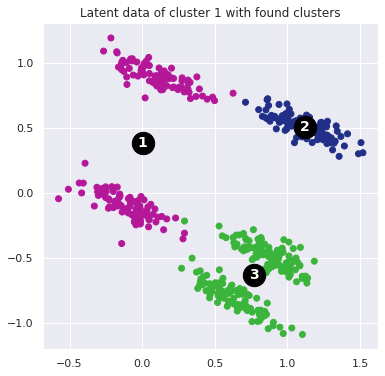

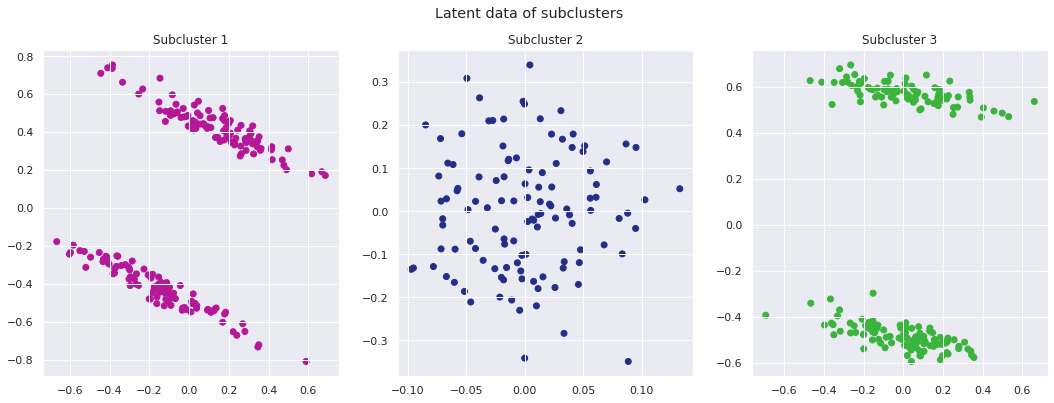

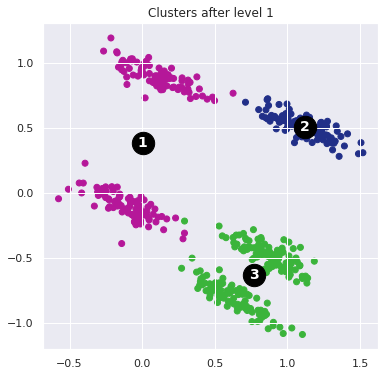

level 2:
Cluster 1:


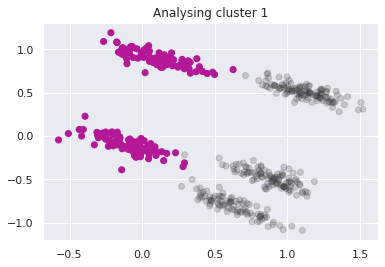

First guess: cluster 1 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 2 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 2 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 2 clusters.
MoPPCAS was looking for 3 clusters, but found only 2 clusters.


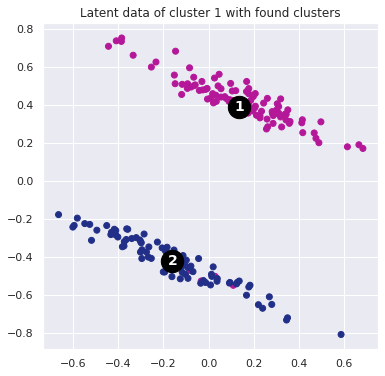

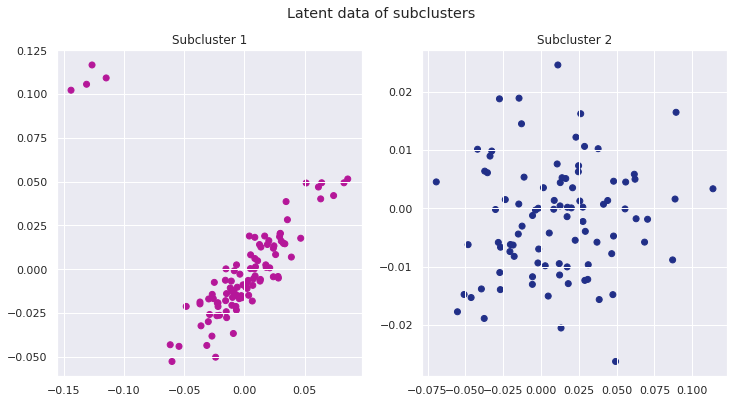

Cluster 2:


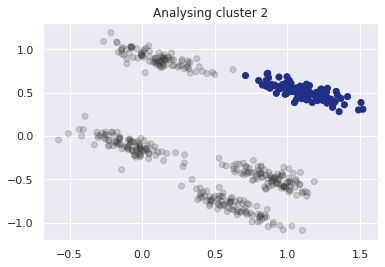

First guess: cluster 2 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
MoPPCAS was looking for 3 clusters, but no more subclusters were found.


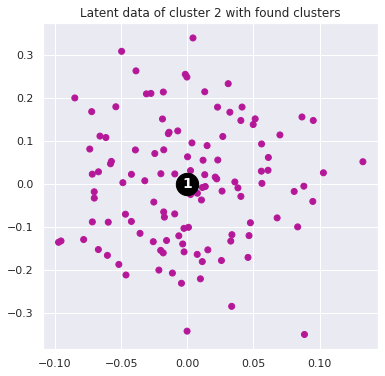

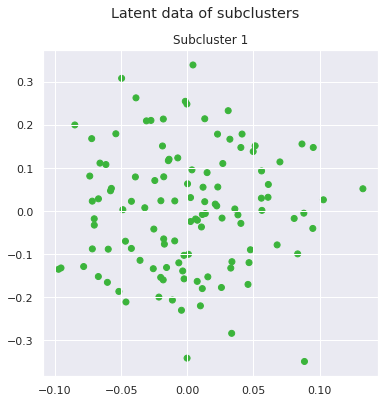

Cluster 3:


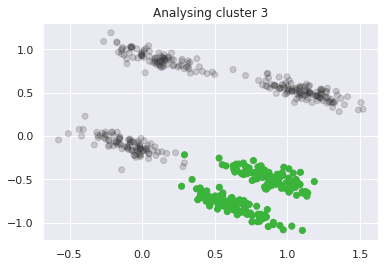

First guess: cluster 3 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 2 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 2 clusters.
MoPPCAS was looking for 3 clusters, but found only 2 clusters.


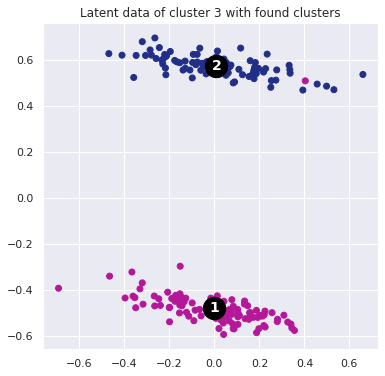

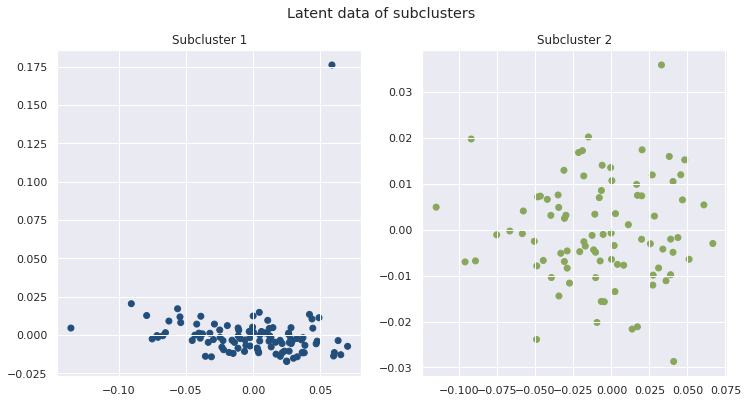

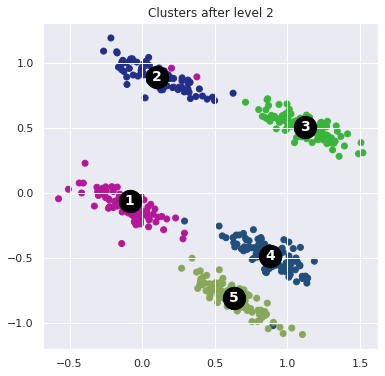

All clusters are fully analyzed!


In [6]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data, max_depth=5, k_max=3)

## Splatter 2 (Larger and more complex)

## Loading data

In [14]:
with open('../Splatter/bigsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/bigsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [15]:
print(data[:6,:6])
print(labels[:6])

[[152  14  30  64   2 256]
 [ 88   6  12  46   0 198]
 [165  28  21  94   8 404]
 [129  32  39  54   1 364]
 [107  17  22  38   4 302]
 [104  23  22  44   3 229]]
[5 2 5 4 4 4]


In [16]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 126
1 	 59
2 	 49
3 	 11
4 	 245
5 	 110


### Loading/Saving  formatted data

In [17]:
# with open('big_splat.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [18]:
data, labels = pickle.load(open('big_splat.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 400)


## Pre-analysis

### Some explames of distributions of genes

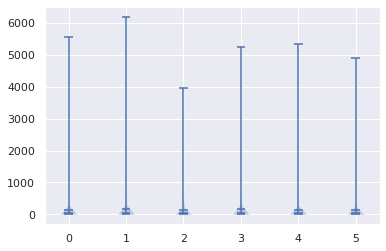

In [50]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

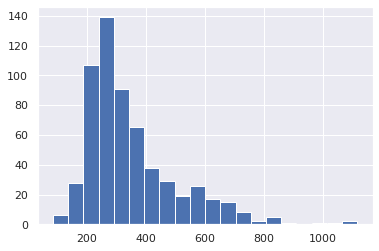

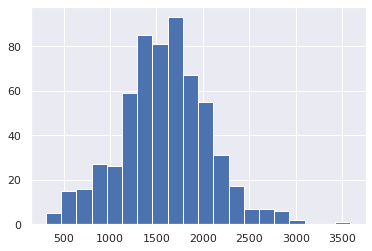

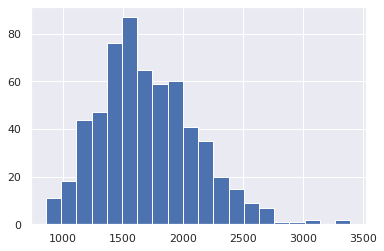

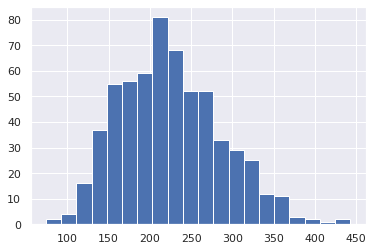

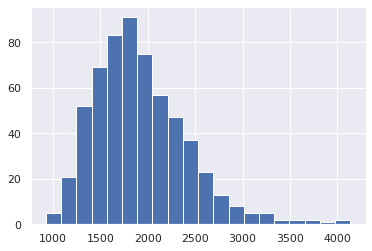

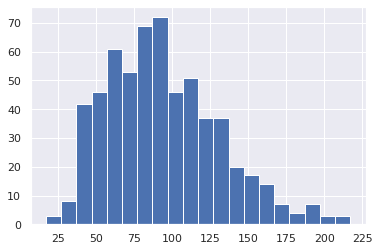

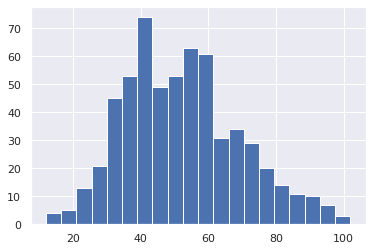

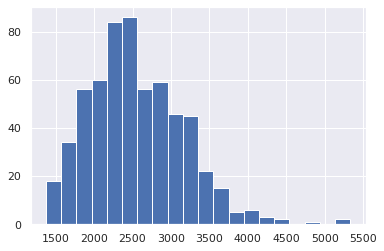

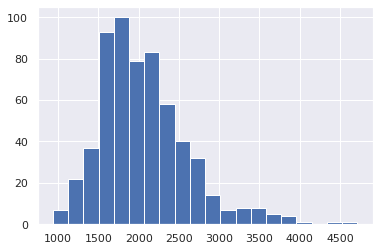

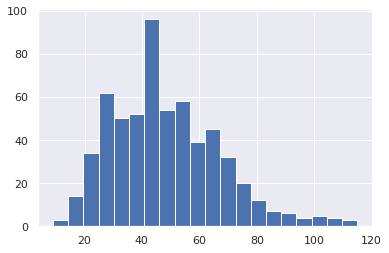

In [51]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=20)
    plt.show()

## Preprocessing

### Transform data

In [19]:
data = np.log2(data+1)

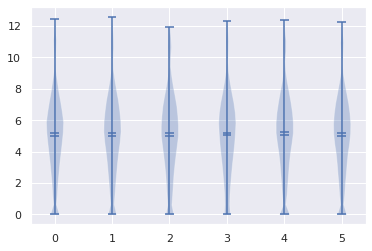

In [53]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

### Loading/Saving  preprocessed data

In [20]:
# with open('bigsplat_prep.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [2]:
data, labels = pickle.load(open('bigsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 400)


### Number of clusters is estimated fairly high

In [84]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

Estimated number of clusters:  15


### Some classes can be observed

In [81]:
n_test = 6
labels_test = KMeans(n_test).fit(data).labels_

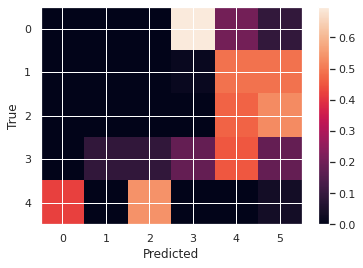

In [82]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [83]:
adjusted_rand_score(labels, labels_test)

0.483979716499772

## Analysis

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


In [2]:
data, labels = pickle.load(open('bigsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 400)


Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Latent data on top level:


Estimated number of clusters on top-level data: 3 (out of a maximum of) 3


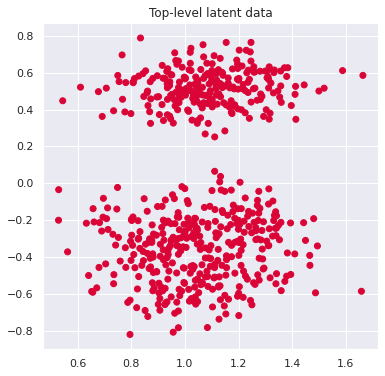

level 1:
Cluster 1:
First guess: cluster 1 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
MoPPCAS was looking for 3 clusters, but no more subclusters were found.


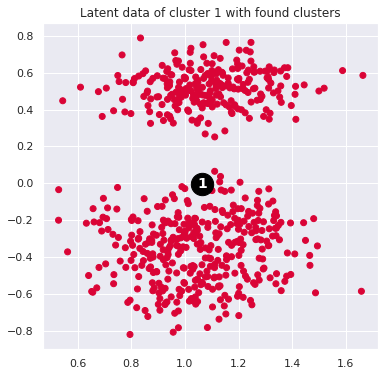

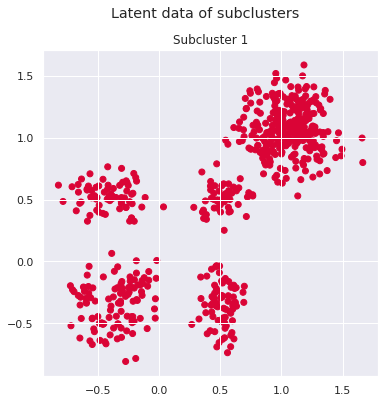

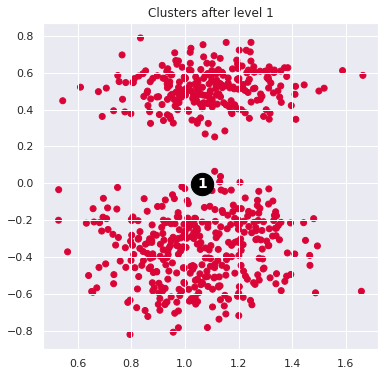

All clusters are fully analyzed!


In [4]:
model2 = hierarchical_model()
latent2, cats_per_lvl2, probs2 = model2.fit(data)